In [ ]:
#https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
cmap = plt.get_cmap('jet_r')
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit
import folium
import branca
%matplotlib inline

In [2]:
from data_loader import df_countries, df_table, continent_dict
df_latest = df_table[df_table['Date'] == max(df_table['Date'])].reset_index()
df_latest_grouped = df_latest.groupby('Country/Region')[
    'Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
has_states = np.unique(df_table[df_table['Province/State']!='NA']['Country/Region'])

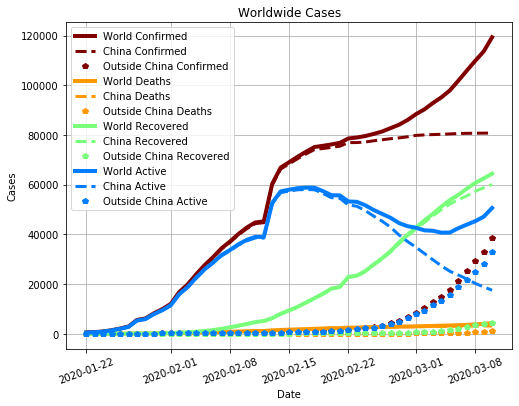

In [3]:
# Worldwide cases
plt.figure(figsize=(8, 6))
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
country = 'China'
#continent = 'Asia'
for ic, col in enumerate(cols):
    plt.plot(df_table.groupby('Date').sum()[col], '-', 
             c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=4, label='World '+col)
    plt.plot(df_table[df_table['Country/Region']==country].groupby('Date').sum()[
        col], '--', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=country+' '+col)
    #plt.plot(df_table[df_table['Continent']==continent].groupby('Date').sum()[
    #    col], ':', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=continent+' '+col)
    plt.plot(df_table[df_table['Country/Region']!=country].groupby('Date').sum()[
        col], 'p', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label='Outside '+country+' '+col)

plt.title('Worldwide Cases')
plt.xlabel('Date')
plt.xticks(rotation=20)
plt.ylabel('Cases')
plt.grid()
plt.legend()
plt.savefig('../figs/world_cases.png')

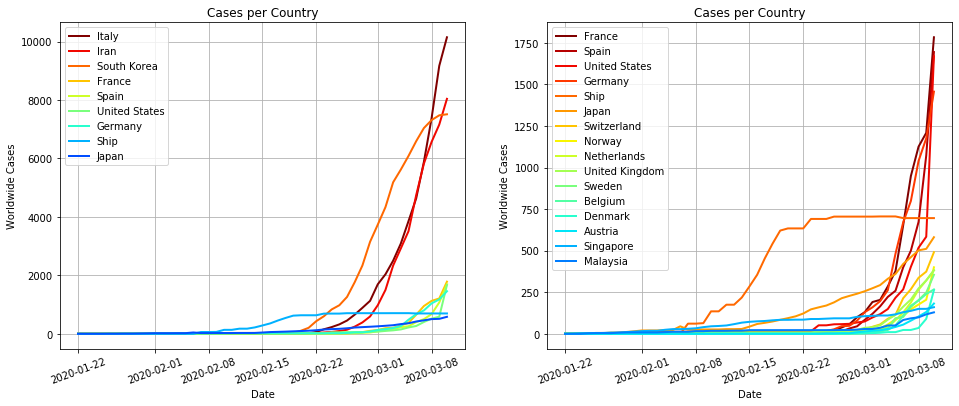

In [4]:
# Cases per country
plt.figure(figsize=(16, 6))
Nc = [[1,10],[4,20]]
for ifig in range(2):
    plt.subplot(1, 2, ifig+1)
    countries = df_latest_grouped.sort_values(by='Confirmed', ascending=False)['Country/Region'].values[Nc[ifig][0]:Nc[ifig][1]]
    for ic, country in enumerate(countries):
        df_c = df_table[df_table['Country/Region']==country]
        if country in has_states:
            plt.plot(df_c.groupby('Date').sum()['Confirmed'], '-', c=cmap(np.arange(0, 1, 1./Nc[ifig][1]))[ic], 
                     label=country, linewidth=2)
        else:
            plt.plot(df_c['Date'], df_c['Confirmed'], '-', c=cmap(np.arange(0, 1, 1./Nc[ifig][1]))[ic], 
                     label=country, linewidth=2)
    plt.title('Cases per Country')
    plt.xlabel('Date')
    plt.xticks(rotation=20)
    plt.ylabel('Worldwide Cases')
    plt.grid()
    plt.legend()

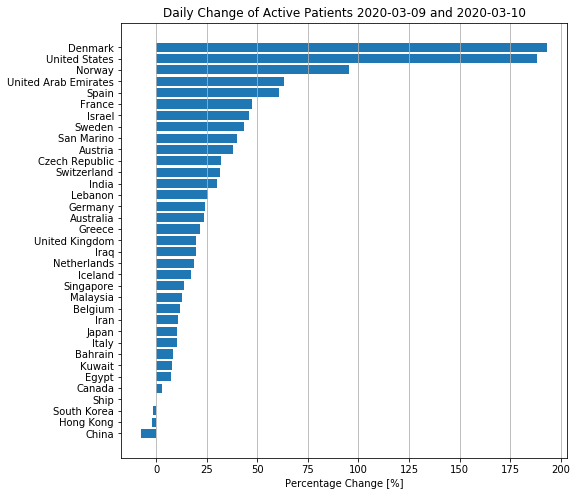

In [5]:
# Recent Growth Rate
d1 = '2020-03-09'
d2 = '2020-03-10'
countries = df_latest_grouped.sort_values(
    by='Confirmed', ascending=False)['Country/Region'].values
daily_growth_confirmed = {}
df_growth = pd.DataFrame(columns=['Country', 'Growth', 'Confirmed'])
for country in countries:
    df_c = df_table[df_table['Country/Region']==country]
    if country in has_states:
        conf1 = df_c[df_c['Date']==d1]['Active'].sum()
        conf2 = df_c[df_c['Date']==d2]['Active'].sum()
    else:
        conf1 = df_c[(df_table['Date']==d1)]['Active'].values[0]
        conf2 = df_c[(df_table['Date']==d2)]['Active'].values[0]
    dg = 100*(conf2-conf1)/conf1
    if (conf1>30):
        daily_growth_confirmed[country] = dg
        df_growth = df_growth.append(pd.DataFrame({'Country':[country], 'Growth':[dg], 'Confirmed':[conf2]}))
#df_growth = pd.DataFrame.from_dict(daily_growth_confirmed, orient='index', columns=['Growth_Rate']).sort_values(
#    by='Growth_Rate',ascending=True)
#df_growth.plot.barh(colormap='jet', figsize=(8, 6), grid=True,
#                    title='Daily Growth Rate Between ' + d1 + ' and ' + d2);
df_growth = df_growth.sort_values(by='Growth', ascending=False)
fig, ax = plt.subplots(figsize=(8, 8))
y_pos = np.arange(len(df_growth['Country'].values))
ax.barh(y_pos, df_growth['Growth'].values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_growth['Country'].values)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Daily Change of Active Patients ' + d1 + ' and ' + d2)
ax.set_xlabel('Percentage Change [%]')
ax.xaxis.grid() # vertical lines
plt.savefig('../figs/daily_growth.png')

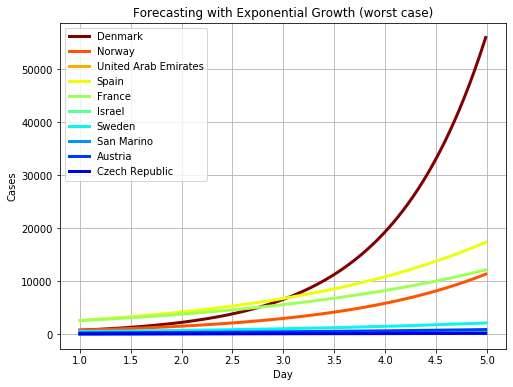

In [7]:
# Very simple but not realistic forecasting
delt = 0.01
t = np.arange(1, 5, delt)
plt.figure(figsize=(8, 6))
Nc = 10
for irow, row in enumerate(df_growth.iterrows()):
    if (irow == 1) or (irow > Nc): continue
    y = row[1]['Confirmed']*np.power(1.+row[1]['Growth']/100., t)
    plt.plot(t, y, '-', linewidth=3, c=cmap(np.arange(0, 1, 1./(Nc+1)))[irow],
             label=row[1]['Country'])
plt.grid()
plt.title('Forecasting with Exponential Growth (worst case)')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.legend()

In [ ]:
#df_full = df.groupby(['Country/Region', 'Province/State']).agg({
#    'Confirmed':'max', 'Deaths':'max', 'Recovered':'max','Lat':'mean', 'Long':'mean'})

In [ ]:
r = 100+(np.log10(df_latest['Confirmed']))*2e4
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, np.max(r.values))

In [ ]:
m = folium.Map(location=[0, 0], tiles='Stamen Toner',
               min_zoom=1, max_zoom=10, zoom_start=1)
for i in range(df_latest.shape[0]):
    folium.Circle(location=[df_latest.iloc[i]['Lat'], df_latest.iloc[i]['Long']],
                  radius=r[i], color='red', 
                  tooltip = '<li><bold>Country: ' + df_latest.iloc[i]['Country/Region'] + '</bold</li>' + 
                  '<li><bold>Province: ' + df_latest.iloc[i]['Province/State'] + '</bold</li>' +  
                  '<li><bold>Lat: ' + str(df_latest.iloc[i]['Lat']) + '</bold</li>' +  
                  '<li><bold>Long: ' + str(df_latest.iloc[i]['Long']) + '</bold</li>' +  
                  '<li><bold><font color="red">Confirmed: ' + str(df_latest.iloc[i]['Confirmed']) + '</font></bold</li>' + 
                  '<li><bold>Deaths: ' + str(df_latest.iloc[i]['Deaths']) + '</bold</li>' + 
                  '<li><bold><font color="green">Recovered: ' + str(df_latest.iloc[i]['Recovered']) + '</font></bold</li>',
                  fill_color='red', opacity=1
                 ).add_to(m)
m